# 1 Classifier for cluster membership 2

Feb 15, 2022

This note book uses the large data set I created earlier, and will explore the use of weights and biases wand.ai.

## 1.1 Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

import wandb # weight and bias model outcome tracking

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
    sns.set_style(
        style='darkgrid',
        rc={'axes.facecolor': '.9', 'grid.color': '.8'}
    )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

TensorFlow version: 2.7.0
TensorFlow Probability version: 0.15.0


2022-02-22 15:35:14.780067: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2 Notebook Python definitions

In [2]:
#
# Produce the sample file for the membership classsification
#
def write_galaxy_sample_for_membership (gal_df, output_filename) :
    # model photo-z as a gaussian of sigma=0.03
    z = gal_df["redshift"]
    pz = z+np.random.normal(0,0.03, size=z.size)
    # if the pz < 0, flip it about 0
    ix, = np.where(pz<0)
    pz[ix] = np.abs(pz[ix])
    is_central = gal_df["is_central"]
    cl_id = gal_df["cluster_id"]
    halo_id = gal_df["halo_id"]
    # set the central galaxies to no pz error
    ix = ((is_central==True) & (cl_id == halo_id))
    pz[ix] = z[ix]
    delta_pz = pz - gal_df["cluster_z"]

    print("sm")
    cosmos=cosmology.setCosmology('planck18')
    luminosity_distance_gal = cosmos.luminosityDistance(pz)
    luminosity_distance_cl = cosmos.luminosityDistance(gal_df["cluster_z"])
    delta_dm = 5*np.log10(luminosity_distance_gal/luminosity_distance_cl)
    gal_smass = gal_df["stellar_mass"] - delta_dm

    print("radius")
    angular_diameter_distance = cosmos.angularDiameterDistance(gal_df["cluster_z"])
    degrees_per_mpc = (1./angular_diameter_distance)*(360./2/np.pi)
    cluster_radius_mpc = gal_df["cluster_radius_arcmin"]/60./degrees_per_mpc

    print("prep galaxies")
    galaxies_in = pd.DataFrame({})
    galaxies_in["radius"] = cluster_radius_mpc
    galaxies_in["delta-pz"] = delta_pz
    galaxies_in["stellarmass"]= gal_smass
    galaxies_in["cl_z"] = gal_df["cluster_z"]
    galaxies_in["i_mag"]=gal_df["mag_i"]
    galaxies_in["u-g"] = gal_df["mag_u-g"]
    galaxies_in["g-r"] = gal_df["mag_g-r"]
    galaxies_in["r-i"] = gal_df["mag_r-i"]
    galaxies_in["i-z"] = gal_df["mag_i-z"]
    cluster_member = (gal_df["halo_id"] == gal_df["cluster_id"])
    cluster_member = np.array(cluster_member).astype("int")
    galaxies_in["member"] = cluster_member
    galaxies_in["id"] = galaxies_in.index


    print("starting to write")
    galaxies_in.to_csv(output_filename) #"~/Data/galaxies_near_clusters_small.csv"
    print("wrote {} {} gals".format(output_filename, galaxies_in["radius"].size))




## 1.2 Data

Set need_to_generate_classification_file to True if one needs to re-generate the classification data file.

- cluster_df: data on the clusters
- galaxy_df: galaxies projected on sky near clusters
- class_df: gaalxy data ready for the classification step


In [3]:
data_directory = "~/Data/cl_sm_dc2_2021/"
cluster_file = data_directory + "cluster_data_0.3-0.6.csv"
galaxy_file = data_directory + "galaxies_near_clusters_0.3-0.6.csv"
classification_file = data_directory + "tmp_galaxies_near_clusters.csv"

gal_df = pd.read_csv(galaxy_file, index_col=0)
cluster_df = pd.read_csv(cluster_file, index_col=[0])

need_to_generate_classification_file  = False
if need_to_generate_classification_file:
    print(gal_df.head())
    write_galaxy_sample_for_membership (gal_df, classification_file)
class_df = pd.read_csv(classification_file, index_col=[0])

class_df

,radius,delta-pz,stellarmass,cl_z,i_mag,u-g,g-r,r-i,i-z,member,id
0,1.390108,-0.293219,14.017486,0.377169,16.710154,1.717278,0.932936,0.455732,0.321991,0,0
1,0.316237,-0.197764,12.619263,0.377169,17.553968,1.706240,1.123459,0.494001,0.287647,0,1
2,0.288371,-0.191983,11.548679,0.377169,19.848861,1.695599,1.063702,0.464962,0.269772,0,2
3,0.275092,-0.200805,11.742450,0.377169,19.362929,1.733788,1.121321,0.481617,0.299284,0,3
4,1.672411,-0.137856,11.478700,0.377169,18.689300,1.673197,1.098970,0.491835,0.312542,0,4
...,...,...,...,...,...,...,...,...,...,...,...
286638,0.588458,1.414640,8.140346,0.597763,22.918548,0.222723,0.081356,-0.069790,0.103909,0,286638
286639,1.664408,1.510623,8.285113,0.597763,21.749791,0.250183,0.053087,-0.095989,0.021654,0,286639
286640,2.335535,1.572470,7.462159,0.597763,22.833552,0.206095,-0.005110,-0.104212,-0.048845,0,286640
286641,1.800517,1.731519,7.957765,0.597763,22.325692,0.147905,-0.050097,-0.102432,-0.082043,0,286641


## 2.2 Prepare the data for training

In [4]:
train,test = sklearn.model_selection.train_test_split(class_df, train_size=0.80)
#X_t = sklearn.preprocessing.StandardScaler.fit_transform(train)
X = train[train.columns[:-2]]
y = train[train.columns[-2]]
print("X, y:", X.shape, y.shape)
X_test = test[test.columns[:-2]]
y_test = test[test.columns[-2]]

train = tf.data.Dataset.from_tensor_slices( (X, y)).shuffle(10000).batch(1000)

all_X = class_df[class_df.columns[:-2]]
all_y = class_df[class_df.columns[-2]]

X, y: (229314, 9) (229314,)


## 2.3 Prepare and train the NN

In [5]:
# Note that when using the delayed-build pattern (no input shape specified),
# the model gets built the first time you call `fit`, `eval`, or `predict`,
# or the first time you call the model on some input data.
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(64,activation='relu', input_dim=9))
#model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

n_epochs=100
Saved_Model_Name = '~/Data/Models/cluster_membership-{}e'.format(n_epochs)
start = time.time()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
doRun = False

if doRun:
    wandb.init(project="classifier-for-cl-membership-2", entity="annis")
    wandb.config = {
        "epochs": n_epochs,
    }
    model.fit(X,y, epochs=n_epochs)
    #model.fit(X,y, epochs=100)
    end = time.time()
    print("optimizing time: {:2f} seconds".format(end - start))

    print(model.summary())
    score = model.evaluate(X_test, y_test, verbose=1)

    print("Test Score:", score[0])
    print("Test Accuracy: {:.2f}%".format(score[1]*100))
    wandb.log({"score":score[0], "accuracy":score[1]*100})
    wandb.finish()
    model.save(Saved_Model_Name)

In [6]:

model = tf.keras.models.load_model(Saved_Model_Name)

membership = np.squeeze(model.predict(all_X))
membership.shape, all_X.shape, all_y.shape

((286643,), (286643, 9), (286643,))

### 2.3.1 testing cells

In [7]:
print("highest mass cluster:   ",np.argmax(cluster_df["halo_mass"]))
z=cluster_df.iloc[251]; print (z["halo_id"].astype("int"))

class_df["memb_prob"] = membership
zz = gal_df[gal_df["cluster_id"]==79700142331]
zz_id = zz.index
zg=class_df[class_df["id"].isin(zz_id)]  # vector instead of scalar or matching length
print(zz.shape, zg.shape, zz_id.shape, np.unique(zz_id).shape)

highest mass cluster:    251
79700142331
(1050, 15) (1050, 12) (1050,) (1050,)


if member, sum(memb_prob*sm):   12.527417459238698 12.647303
         dec         ra  redshift  halo_mass  stellar_mass       halo_id  \
0 -39.595058  61.754715  0.377169  14.658120  1.305021e+12  268600155355   
1 -41.089805  62.125393  0.385860  14.089678  7.850036e+11  397200155355   
2 -39.809490  62.668306  0.374379  14.383239  5.800606e+11  449800155355   
3 -41.168704  61.504270  0.377054  14.287383  6.616984e+11  562900155355   
4 -41.012162  61.380974  0.435655  14.141557  4.252299e+11  467800155338   

   central_sm    sm_0.50    sm_0.67     sm_1.0     sm_1.5     sm_2.0  \
0   12.115618  12.476259  12.515145  12.572289  12.584593  12.584593   
1   11.894872  11.958520  11.985133  11.995679  11.995679  11.995679   
2   11.763473  12.158964  12.191358  12.205451  12.217457  12.218066   
3   11.820660  12.242907  12.271576  12.326310  12.339697  12.339697   
4   11.628624  11.994025  12.073444  12.181086  12.181086  12.181086   

      sm_3.0  stellarmass  
0  12.584593    12.58

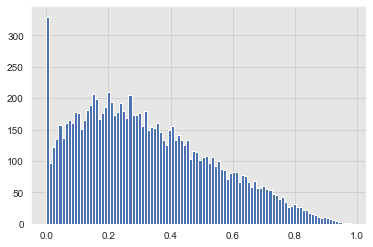

In [8]:
sm = (zg["memb_prob"]*zg["member"]*10**(zg["stellarmass"])).sum();
sm = np.log10(sm); print("if member, sum(memb_prob*sm):  ",sm, z["stellarmass"])

print(cluster_df.head(), "\n\nstellar_mass is central galaxy, stellarmass is the total cluster stellar mass")

class_df["memb_prob"] = membership
cnt,bins,junk=plt.hist(class_df[class_df["memb_prob"]>0.1]["radius"], bins=100, weights=membership[membership>0.1])

## 2.4

In [20]:
#  norm_count, axes = plot_radial_profile(class_df)
#  norm_count, axes = plot_radial_profile(class_df, norm_count, axes)

def plot_radial_profile(galaxies, norm_count = 0, axes= "" ) :
    if len(axes) == 0 :
        ax=0
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), constrained_layout=True)
        axes[ax].set_yscale("log")
    else :
        ax=1
        axes[ax].set_yscale("linear")


    lim_prob = 1e-3
    inside = galaxies[galaxies["memb_prob"]>lim_prob]
    weights = membership[membership>lim_prob]
    cnt,bins=np.histogram(inside["radius"], bins=100, weights=weights)
    if type(norm_count) == int : norm_count = bins[1:]**2 #

    for lim_prob in [1e-3, 1e-2, 0.1, 0.2]:
        inside = galaxies[galaxies["memb_prob"]>lim_prob]
        weights = membership[membership>lim_prob]#*inside["member"] # membership_prob * member is the best performance
        cnt,abins=np.histogram(inside["radius"], bins=bins, weights=weights)
        sns.scatterplot(x=bins[1:], y=cnt/norm_count, ax=axes[ax])

    inside = galaxies[galaxies["member"]==1]
    cnt,bins=np.histogram(inside["radius"], bins=100)
    #sns.lineplot(x=bins[1:], y=cnt/(bins[1:]**2), color="k",  ax=axes[0])
    sns.scatterplot(x=bins[1:], y=cnt/norm_count, ax=axes[ax], color="k")


    xlab = "radius (Mpc)"
    if ax == 0:
        ylab = "$\sum$galaxies$/2\pi r^2$"
    else:
        ylab = r"$\sum$galaxies$/\sum$galaxies$(p_i>10^{-3})$"
    axes[ax].set_xlabel(xlab)
    axes[ax].set_ylabel(ylab)
    axes[ax].legend(labels=[r"$p>10^{-3}$",r"$p>10^{-2}$",r"$p>10^{-1}$",r"$p>0.2$", "truth"])

    if ax == 1:
        axes[ax].set_ylim(-0.5,2.0)

    return norm_count, axes

#plt.savefig("radial_profile.png")

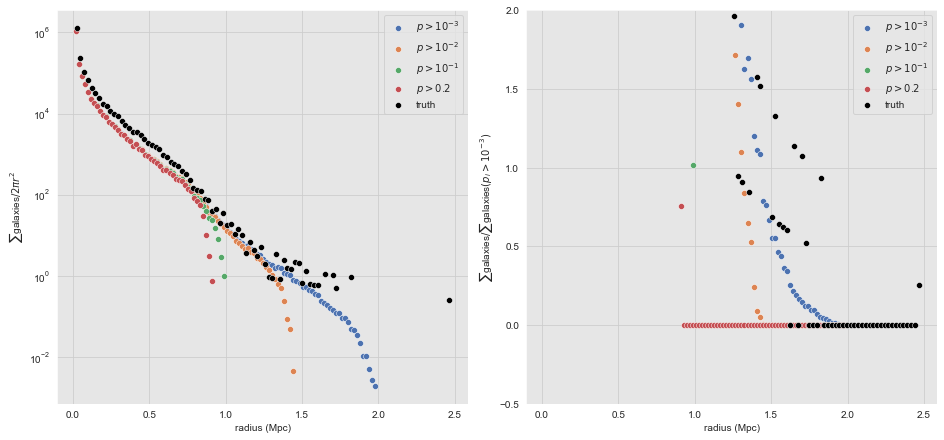

In [21]:
norm_count, axes = plot_radial_profile(class_df)
norm_count, axes = plot_radial_profile(class_df, norm_count, axes)